# Mô hình Transformer + Kalman dự báo giá cổ phiếu Vietcombank

## Đọc dữ liệu làm mịn bằng bộ lọc Kalman

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import os
from filterpy.kalman import KalmanFilter

# Load and prepare the dataset
file_path = '/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/Data/vcb_2010-2024.csv' 
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df[::-1].reset_index(drop=True)
df.set_index('Date', inplace=True)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Apply Kalman Filter to smooth the data
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[1., 0.], [0., 1.]])
    smoothed_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        smoothed_data.append(kf.x[0])
    return np.array(smoothed_data).reshape(-1, 1)

data_kalman = apply_kalman_filter(data_scaled)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Only take the 'Close' value for y
    return np.array(dataX), np.array(dataY)

/tmp/ipykernel_746/3669838992.py:16: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


### Biểu đồ đường giá CLOSE của cổ phiếu Vietcombank trước và sau khi sử dụng bộ lọc Kalman

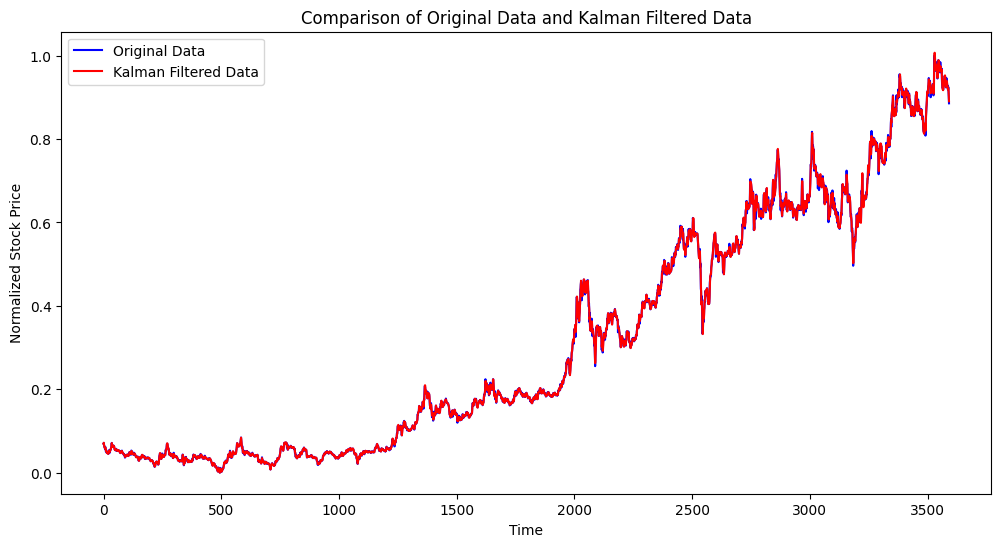

In [22]:
# Plot the data before and after applying Kalman Filter
plt.figure(figsize=(12, 6))
plt.plot(data_scaled, label='Original Data', color='blue')
plt.plot(data_kalman, label='Kalman Filtered Data', color='red')
plt.title('Comparison of Original Data and Kalman Filtered Data')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()


#### Cũng là biểu đồ trước và sau khi sử dụng Kalman nhưng đã vẽ zoom một khoảng thời gian cụ thể để thấy rõ sự khác biệt

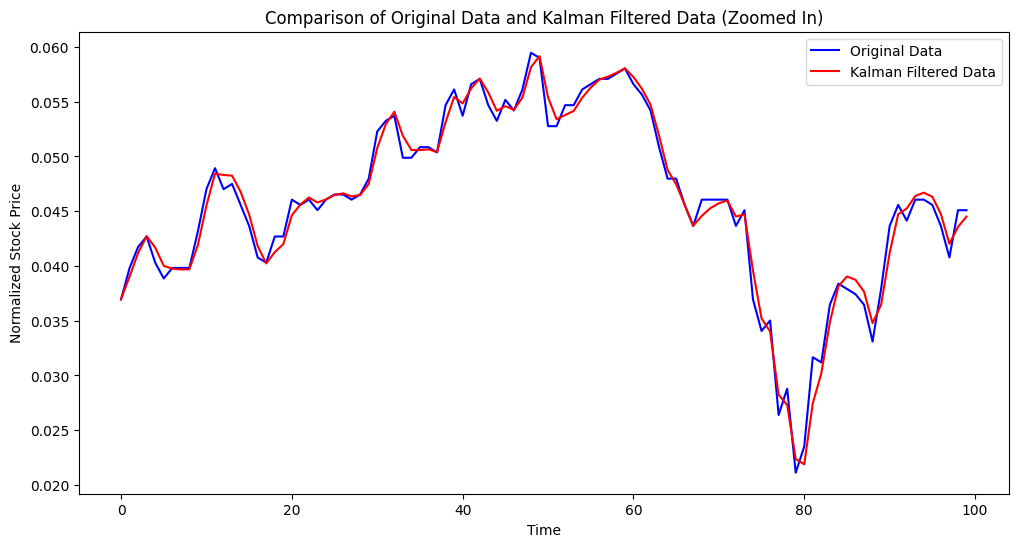

In [23]:
start_idx = 1000
end_idx = 1100

plt.figure(figsize=(12, 6))
plt.plot(data_scaled[start_idx:end_idx], label='Original Data', color='blue')
plt.plot(data_kalman[start_idx:end_idx], label='Kalman Filtered Data', color='red')
plt.title('Comparison of Original Data and Kalman Filtered Data (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()


## Kalman + Transformer với timestep = 30

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 30, 1)]      0           []                               
                                                                                                  
 layer_normalization_26 (LayerN  (None, 30, 1)       2           ['input_14[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_13 (Multi  (None, 30, 1)       7169        ['layer_normalization_26[0][0]', 
 HeadAttention)                                                   'layer_normalization_26[0][0]'] 
                                                                                           

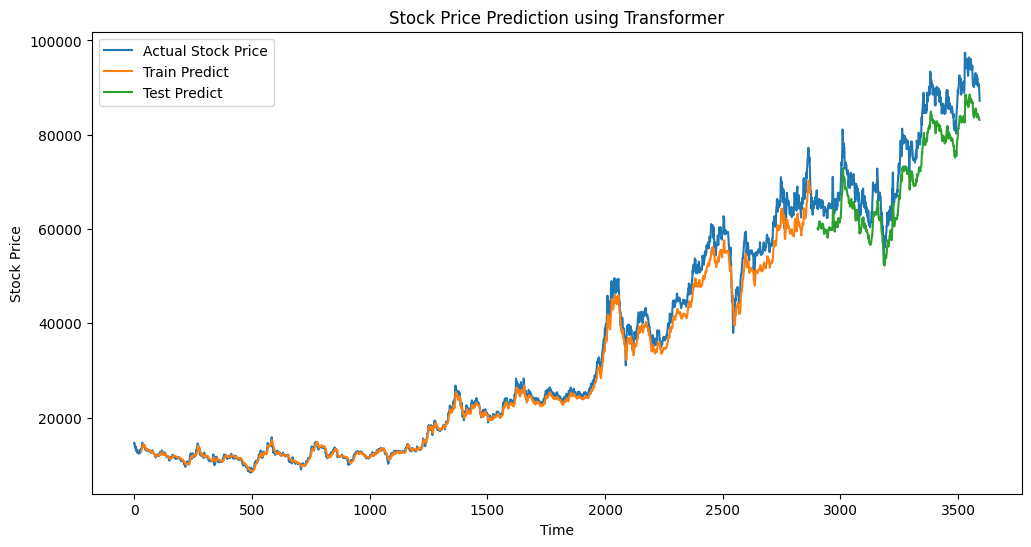

In [33]:
# Parameters
time_step = 30
training_size = int(len(data_kalman) * 0.8)
test_size = len(data_kalman) - training_size
train_data, test_data = data_kalman[0:training_size], data_kalman[training_size:len(data_kalman)]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict_inverse = scaler.inverse_transform(train_predict)
test_predict_inverse = scaler.inverse_transform(test_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = math.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
train_r2 = r2_score(y_train_inverse, train_predict_inverse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Path to save the model
model_path = "best_transformer_model_kalman.h5"

# Check if a model already exists
if os.path.exists(model_path):
    # Load the existing model
    best_model = tf.keras.models.load_model(model_path)
    
    # Evaluate the existing model
    best_model_predict = best_model.predict(X_test)
    best_model_predict_inverse = scaler.inverse_transform(best_model_predict)
    best_model_r2 = r2_score(y_test_inverse, best_model_predict_inverse)
    
    # Compare the new model with the existing model
    if test_r2 > best_model_r2:
        print(f"New model is better (Test R2: {test_r2} > {best_model_r2}). Updating the saved model.")
        model.save(model_path)
    else:
        print(f"Existing model is better (Test R2: {best_model_r2} >= {test_r2}). Not updating the saved model.")
else:
    # Save the new model
    model.save(model_path)
    print(f"No existing model found. Saving the new model.")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict_inverse)+time_step, :] = train_predict_inverse

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_inverse)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict_inverse

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_path = "/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/best_transformer_model_kalman.h5"
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Load the trained model
best_model = tf.keras.models.load_model(model_path)

# Predict using the model
best_model_predict = best_model.predict(X_test)
best_model_predict_inverse = scaler.inverse_transform(best_model_predict)

# Ensure y_test is reshaped correctly
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
r2 = r2_score(y_test_inverse, best_model_predict_inverse)
nse = nash_sutcliffe_efficiency(y_test_inverse, best_model_predict_inverse)
mae = mean_absolute_error(y_test_inverse, best_model_predict_inverse)
rmse = math.sqrt(mean_squared_error(y_test_inverse, best_model_predict_inverse))

# Print the results
print(f"R2: {r2}")
print(f"NSE: {nse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

22/22 [==============================] - 0s 4ms/step
R2: 0.9567527540812841
NSE: 0.9567527540812841
MAE: 1712.2169540075433
RMSE: 2283.0332046175654


## Kalman + Transformer với timestep = 60

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 layer_normalization_14 (LayerN  (None, 60, 1)       2           ['input_8[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 60, 1)       7169        ['layer_normalization_14[0][0]', 
 eadAttention)                                                    'layer_normalization_14[0][0]'] 
                                                                                            

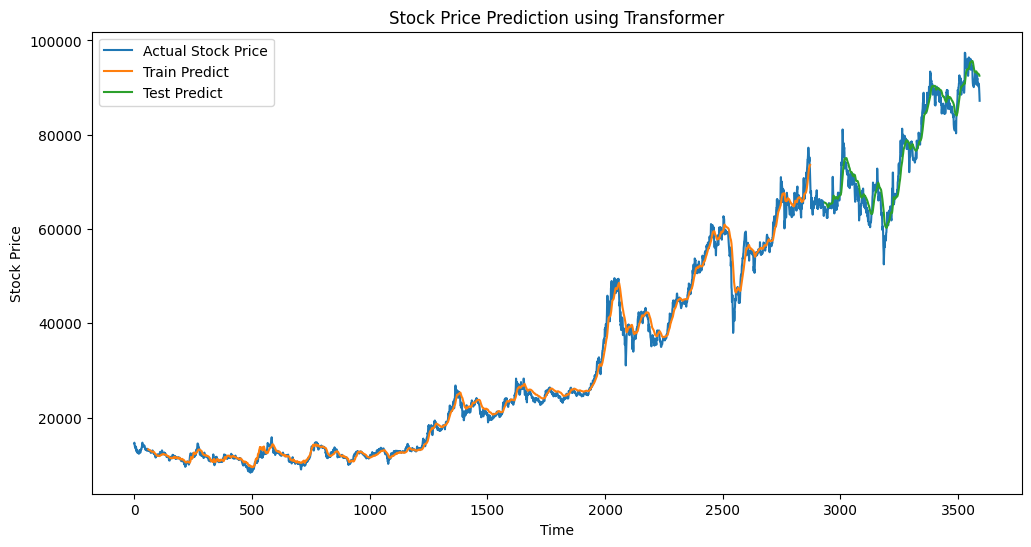

In [26]:
# Parameters
time_step = 60
training_size = int(len(data_kalman) * 0.8)
test_size = len(data_kalman) - training_size
train_data, test_data = data_kalman[0:training_size], data_kalman[training_size:len(data_kalman)]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict_inverse = scaler.inverse_transform(train_predict)
test_predict_inverse = scaler.inverse_transform(test_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = math.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
train_r2 = r2_score(y_train_inverse, train_predict_inverse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Path to save the model
model_path = "best_transformer_model_kalman2.h5"

# Check if a model already exists
if os.path.exists(model_path):
    # Load the existing model
    best_model = tf.keras.models.load_model(model_path)
    
    # Evaluate the existing model
    best_model_predict = best_model.predict(X_test)
    best_model_predict_inverse = scaler.inverse_transform(best_model_predict)
    best_model_r2 = r2_score(y_test_inverse, best_model_predict_inverse)
    
    # Compare the new model with the existing model
    if test_r2 > best_model_r2:
        print(f"New model is better (Test R2: {test_r2} > {best_model_r2}). Updating the saved model.")
        model.save(model_path)
    else:
        print(f"Existing model is better (Test R2: {best_model_r2} >= {test_r2}). Not updating the saved model.")
else:
    # Save the new model
    model.save(model_path)
    print(f"No existing model found. Saving the new model.")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict_inverse)+time_step, :] = train_predict_inverse

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_inverse)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict_inverse

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [27]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_path = "/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/best_transformer_model_kalman2.h5"
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Load the trained model
best_model = tf.keras.models.load_model(model_path)

# Predict using the model
best_model_predict = best_model.predict(X_test)
best_model_predict_inverse = scaler.inverse_transform(best_model_predict)

# Ensure y_test is reshaped correctly
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
r2 = r2_score(y_test_inverse, best_model_predict_inverse)
nse = nash_sutcliffe_efficiency(y_test_inverse, best_model_predict_inverse)
mae = mean_absolute_error(y_test_inverse, best_model_predict_inverse)
rmse = math.sqrt(mean_squared_error(y_test_inverse, best_model_predict_inverse))

# Print the results
print(f"R2: {r2}")
print(f"NSE: {nse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

21/21 [==============================] - 0s 4ms/step
R2: 0.9487415117110833
NSE: 0.9487415117110833
MAE: 1909.9144100521307
RMSE: 2483.4760976515204
